In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 150
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\sansk\Downloads\chest x ray-20231106T114602Z-001\chest x ray",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5856 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 150, 150, 3)
[1 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1
 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0]


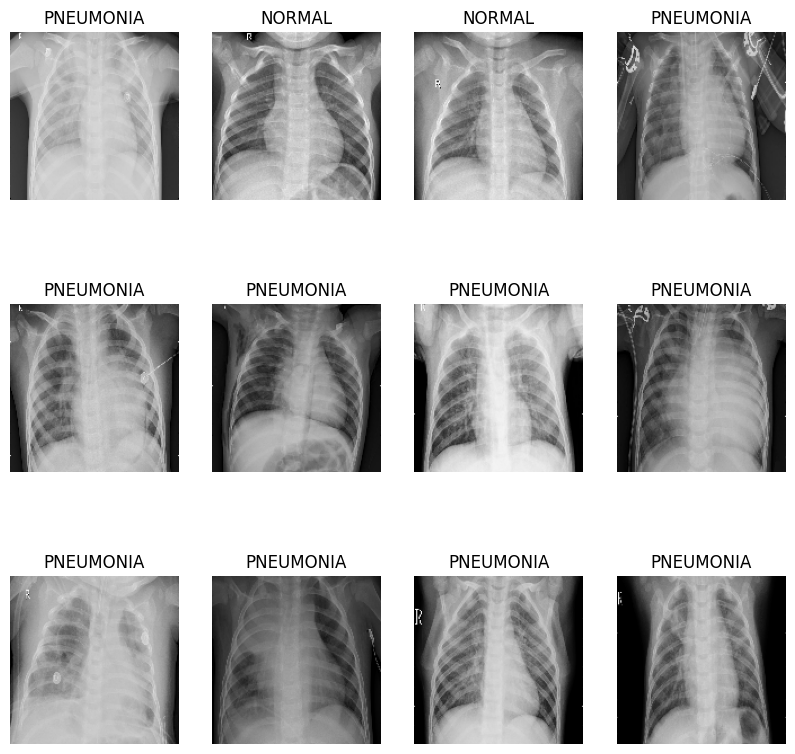

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.3, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.applications.densenet import DenseNet201


In [12]:
model=DenseNet201(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), weights='imagenet',include_top=False)


In [13]:
model.trainable=False

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
base_densenet_model=Sequential([
    resize_and_rescale,
    model
])
base_densenet_model.build(input_shape=input_shape)

In [15]:
custom_densenet_model=Sequential([
    base_densenet_model,
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(2, activation='softmax'),

])


In [16]:
custom_densenet_model.build(input_shape=input_shape)

In [17]:
custom_densenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (64, 4, 4, 1920)          18321984  
                                                                 
 flatten (Flatten)           (64, 30720)               0         
                                                                 
 dense (Dense)               (64, 50)                  1536050   
                                                                 
 dense_1 (Dense)             (64, 20)                  1020      
                                                                 
 dense_2 (Dense)             (64, 2)                   42        
                                                                 
Total params: 19,859,096
Trainable params: 1,537,112
Non-trainable params: 18,321,984
_________________________________________________________________


In [18]:
custom_densenet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = custom_densenet_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
55/55 [==============================] - 46s 354ms/step - loss: 0.2851 - accuracy: 0.9186 - val_loss: 0.1689 - val_accuracy: 0.9369
Epoch 2/50
55/55 [==============================] - 24s 295ms/step - loss: 0.1232 - accuracy: 0.9570 - val_loss: 0.0997 - val_accuracy: 0.9624
Epoch 3/50
55/55 [==============================] - 24s 309ms/step - loss: 0.1116 - accuracy: 0.9584 - val_loss: 0.1660 - val_accuracy: 0.9452
Epoch 4/50
55/55 [==============================] - 25s 305ms/step - loss: 0.1119 - accuracy: 0.9624 - val_loss: 0.0524 - val_accuracy: 0.9826
Epoch 5/50
55/55 [==============================] - 24s 300ms/step - loss: 0.0536 - accuracy: 0.9802 - val_loss: 0.0361 - val_accuracy: 0.9870
Epoch 6/50
55/55 [==============================] - 24s 297ms/step - loss: 0.0501 - accuracy: 0.9811 - val_loss: 0.0259 - val_accuracy: 0.9896
Epoch 7/50
55/55 [==============================] - 24s 301ms/step - loss: 0.0553 - accuracy: 0.9825 - val_loss: 0.0392 - val_accuracy: 0.9850

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

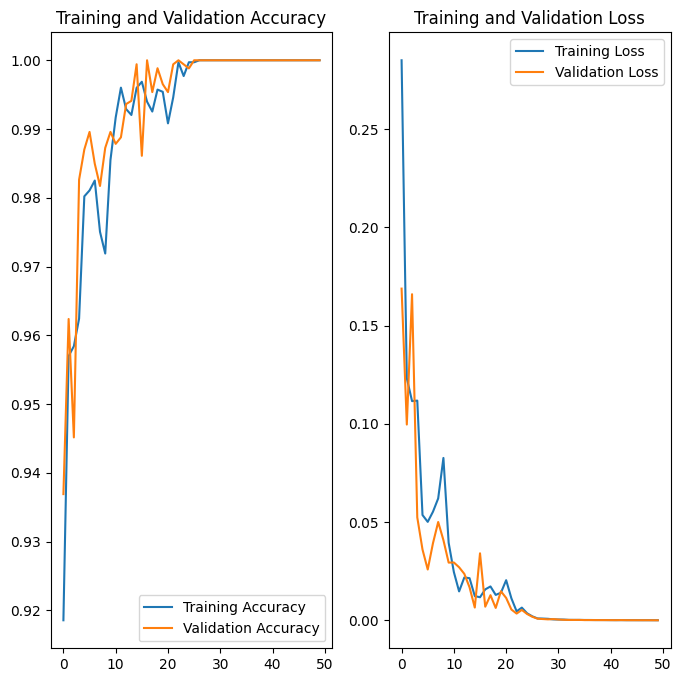

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
import numpy as np
true_labels = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())

In [23]:
predictions = custom_densenet_model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

10/10 [==============================] - 11s 127ms/step


In [24]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.26      0.27      0.27       168
           1       0.74      0.72      0.73       472

    accuracy                           0.60       640
   macro avg       0.50      0.50      0.50       640
weighted avg       0.61      0.60      0.61       640



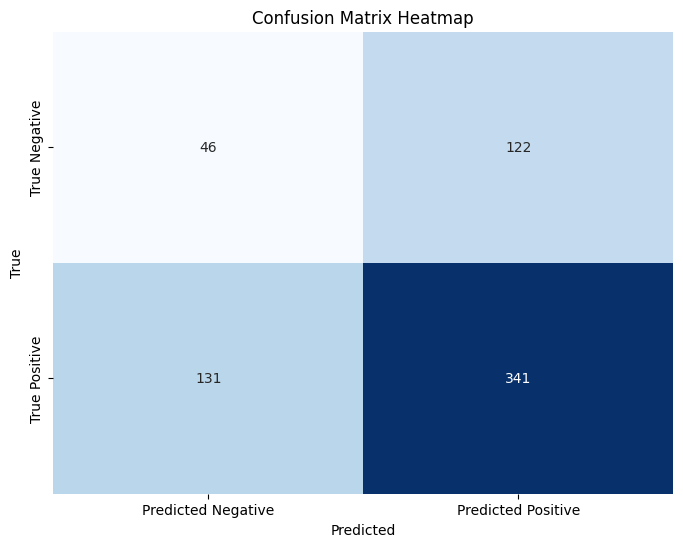

In [25]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(true_labels, predicted_labels)
confusion
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [26]:
test_loss, test_accuracy = custom_densenet_model.evaluate(test_ds)

10/10 [==============================] - 8s 105ms/step - loss: 1.0154e-04 - accuracy: 1.0000


first image to predict
actual label: PNEUMONIA
2/2 [==============================] - 3s 305ms/step
predicted label: PNEUMONIA


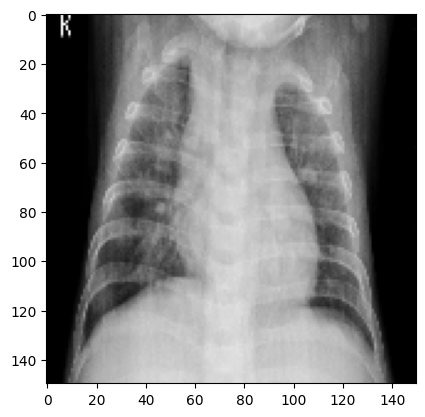

In [27]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = custom_densenet_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [28]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)
    #img_array=tf.image.resize(img_array)
    predictions = model.predict(img_array)
    print(np.argmax(predictions[0]))
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 2s 2s/step
1
1/1 [==============================] - 0s 49ms/step
1
1/1 [==============================] - 0s 47ms/step
1
1/1 [==============================] - 0s 37ms/step
1
1/1 [==============================] - 0s 39ms/step
0
1/1 [==============================] - 0s 39ms/step
1
1/1 [==============================] - 0s 38ms/step
1
1/1 [==============================] - 0s 37ms/step
1
1/1 [==============================] - 0s 38ms/step
1


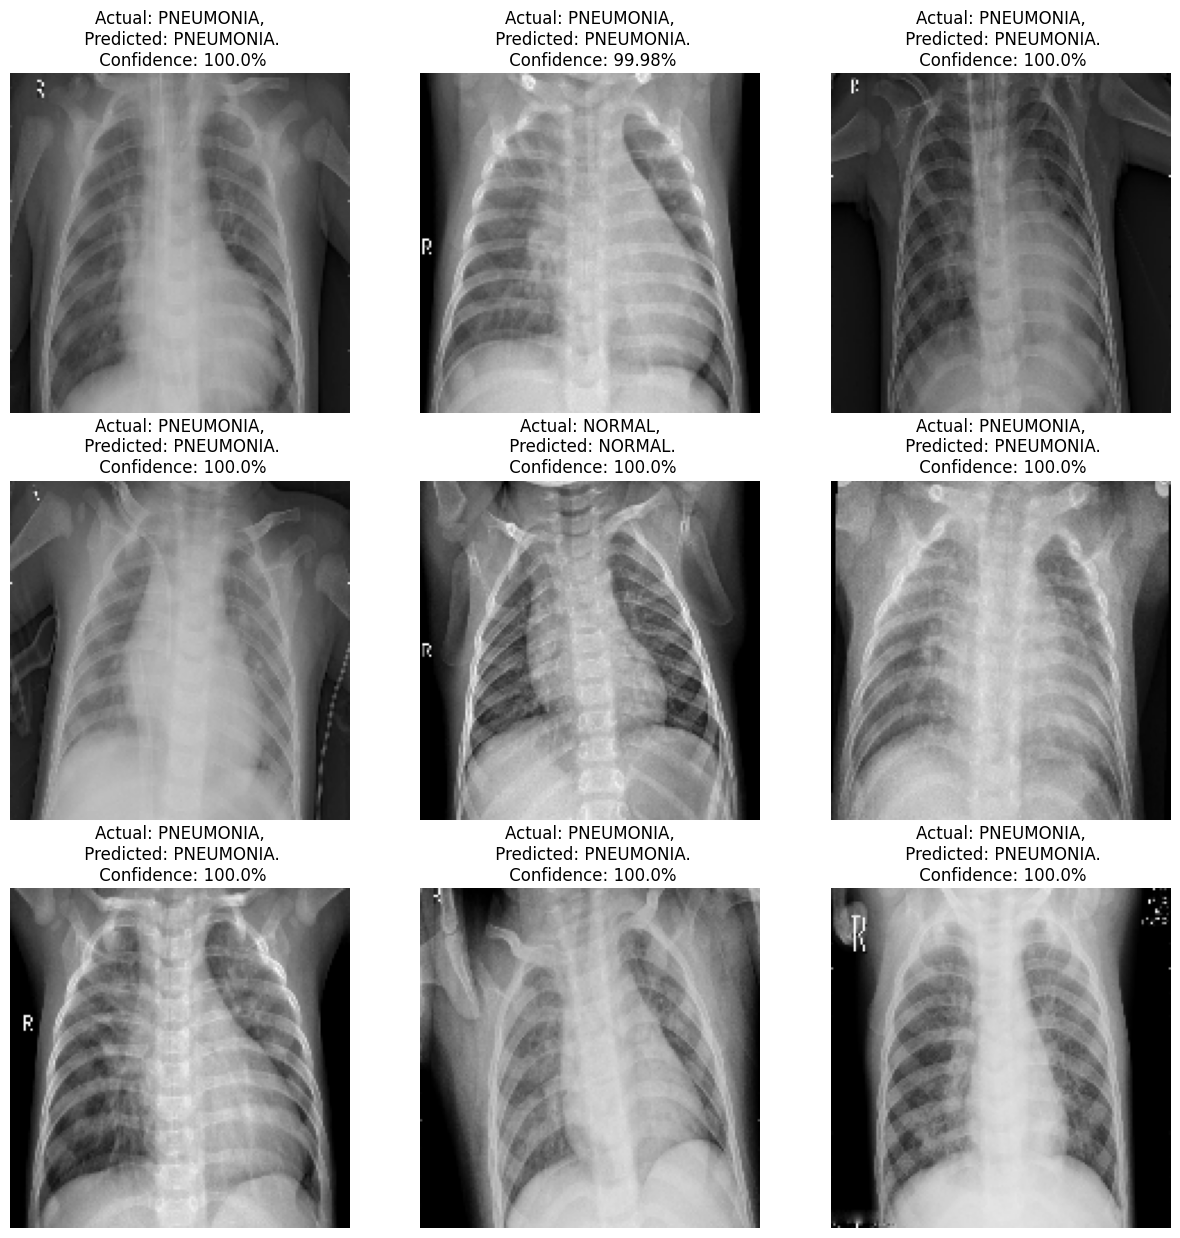

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #img=tf.image.resize(images[i],[IMAGE_SIZE,IMAGE_SIZE])
        #print(images[i].type())
        predicted_class, confidence = predict(custom_densenet_model, images[i])
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")